# Tutorial on Rotated Staggered Grid (RSG)

This is a tutorial to help the users understand the usage of the rotated staggered grid (RSG) package with a 2D example.

This is firstly made to mimic https://github.com/slimgroup/ElasticTTI/blob/master/examples/tti_modeling.py for verification, and then made into this tutorial


The package comes with the following file: 
* `'stiffnessoperator.py'` - a toolkit to prepare the elastic stiffness. The input can be Thomesen's parameter or manually enter 21 elastic constants. It also supports the 3D rotation of the tensor and embed fracture set with the method from Scheonberg and Douma (1988).

* `'model.py'` - A modified version based on the original `'examples/seismic/model.py'`. A new AnisoSeismicModel is added. `vp, vs` are required parameters for compatibility and determine `dt` or `time_step`. Addition input to construct an `AnisoSeismicModel` are the elastic constants `c11,c12,...c66` for space of grids.

* `'wavesolver.py'`/`'operator.py'` - a wrapped solver and operator respectively, formatted to be similar as other devito seismic solver, such as `acoustic`, `elastic`, `tti` in `seismic/examples/`, 

Note: Courant–Friedrichs–Lewy (CFL) criterion determined `dt` or `time_step` is not guaranteed for stability. Users can config this by `geometry._dt = dt`.
 



### Step 1. import all the dependency
make sure the path of rsg is in the path

In [1]:
# make sure the rsg dependency is in the path
import sys
sys.path.append('/home/zhan3386/rsg')
from wavesolver import AnisotropySolver

import devito and common libraries like `numpy` and `matplotlib`

In [2]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
from stiffnessoperator import *
from model import AnisoSeismicModel
from devito import info
from examples.seismic.utils import AcquisitionGeometry
import matplotlib.pyplot as plt

### Step 2. define the computing domain of modeling and parameters

In [3]:
# NBVAL_IGNORE_OUTPUT
so = 8 # spatial order
to = 2 # time order

# Define a physical size
shape = (401, 401)  # Number of grid point (nx, nz)
spacing = (5., 5.)  # Grid spacing in m. The domain size is now 2000m by 2000m.
nbl = 40 # number of points in the boundary layer

dtype = np.float32
origin = (0., 0.)

specify the physical parameters of the grid with one media

In [4]:
vp = 2.4 # in km/s, determine dt or time_step but will not take part in actual modeling
vs = 0.9 # in km/s, determine dt or time_step but will not take part in actual modeling
density = 1.0 # in g/cm^3

C11 = vp**2 * density; # lambda + 2 * mu
C44 = vs**2 * density; # mu
C12 = C11 - 2 * C44 # lambda

# create a stiffnessMatrix object with the given parameters of the media.
stiffnessMat = StiffnessMatrixVTI(vp = vp, vs = vs, rho = density ,epsilon = 0.3, gamma = 0.3,delta= 0.18)

# tilt the stiffness with rotational angle.
stiffnessMat = stiffnessMat.tilt(xiprime = np.pi/20, eta = 0.9)
# stiffnessMat = stiffnessMat.tilt(xiprime = 0.9, eta = np.pi/20)

# create array for each cij, which is further taken in by the AnisoSeismicModel object.
c11,c12,c13,c14,c15,c16,c22,c23,c24,c25,c26,c33,c34,c35,c36,c44,c45,c46,c55,c56,c66 = stiffnessMat.getArray(shape)

Config to make the upper 300 meters (60 indices) a seperate layer made of water (vp=1.5 km/s, vs=0 km/s) 

Create a mask first, then specify the elastic constant (parameters) covered by mask. 

This is certainly not the elegant way to do, but make it easy to understand.

In [5]:
mask_water = np.ones(shape)
mask_water[:, 61:] = 0
mask_water = mask_water.astype(bool)

vp_water = 1.5

# Config the .
c11[mask_water] = vp_water**2 * density; 
c22[mask_water] = vp_water**2 * density;
c33[mask_water] = vp_water**2 * density
c12[mask_water] = vp_water**2 * density
c13[mask_water] = vp_water**2 * density
c23[mask_water] = vp_water**2 * density

c44[mask_water] = 0.; c55[mask_water] = 0.; c66[mask_water] = 0.
c14[mask_water] = 0.; c15[mask_water] = 0.; c16[mask_water] = 0.
c24[mask_water] = 0.; c25[mask_water] = 0.; c26[mask_water] = 0.
c34[mask_water] = 0.; c35[mask_water] = 0.; c36[mask_water] = 0.
c45[mask_water] = 0.; c46[mask_water] = 0.; c56[mask_water] = 0.

buo = np.ones(shape) * 1 / density

### Step 3. Create model and geometry

create `AnisoSeismicModel` object to collect all the prepared parameters and construct a model

In [6]:
model = AnisoSeismicModel(space_order=so, vp=vp, b = buo, origin=origin, shape=shape,
                     spacing=spacing, nbl=nbl, c11=c11,c12=c12,c13=c13,c14=c14,c15=c15,c16=c16,
                                                      c22=c22,c23=c23,c24=c24,c25=c25,c26=c26,
                                                              c33=c33,c34=c34,c35=c35,c36=c36,
                                                                      c44=c44,c45=c45,c46=c46,
                                                                              c55=c55,c56=c56,
                                                                                      c66=c66)

Operator `initdamp` ran in 0.01 s
Operator `pad_b` ran in 0.01 s
Operator `pad_c11` ran in 0.01 s
Operator `pad_c12` ran in 0.01 s
Operator `pad_c13` ran in 0.01 s
Operator `pad_c14` ran in 0.01 s
Operator `pad_c15` ran in 0.01 s
Operator `pad_c16` ran in 0.01 s
Operator `pad_c22` ran in 0.01 s
Operator `pad_c23` ran in 0.01 s
Operator `pad_c24` ran in 0.01 s
Operator `pad_c25` ran in 0.01 s
Operator `pad_c26` ran in 0.01 s
Operator `pad_c33` ran in 0.01 s
Operator `pad_c34` ran in 0.01 s
Operator `pad_c35` ran in 0.01 s
Operator `pad_c36` ran in 0.01 s
Operator `pad_c44` ran in 0.01 s
Operator `pad_c45` ran in 0.01 s
Operator `pad_c46` ran in 0.01 s
Operator `pad_c55` ran in 0.01 s
Operator `pad_c56` ran in 0.01 s
Operator `pad_c66` ran in 0.01 s


define the time axis and the source frequency

In [7]:
t0, tn = 0., 750.  # in ms
dt = 0.6 # in ms

f0 = 0.02  # define the central frequency of source to be 20Hz (0.02 kHz)

specify the source and receiver location (x, z) in meters

In [8]:
src_coordinates = np.array([1000., 20.])
rec_coordinates = np.array([[1250, x] for x in range(100, 2100, 100)]) # a total of 21 VSP receivers

create `AcquisitionGeometry` object to collect all the time axis and source/receiver geometry. 

Note: the time spacing in config to make sure stability

In [9]:
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0=t0, tn=tn, f0=f0, src_type='Ricker')
geometry._dt = dt

### Step 4. Create anisotropy (RSG) solver
The solver will handle the `model` and `geometry` we just prepared.

In [10]:
solver = AnisotropySolver(model=model, geometry=geometry, space_order=so)

### Step 5. Execute the forward modeling operator
the stress moment is config to be `iso` (explosive source in all dimensions with no shear)
and run 300 steps (each one is 0.6ms, so total 180 ms)

The return objeccts are:
* rec - the results of the receivers
* v - wavefield of the velocity
* tau - wavefield of the stress
* summary - performance summary

In [11]:
rec, v, tau, summary = solver.forward(moment = "iso", dt=dt)

Operator `ForwardAnisoElastic` ran in 4.31 s


### Step 6. Plot the wavefield

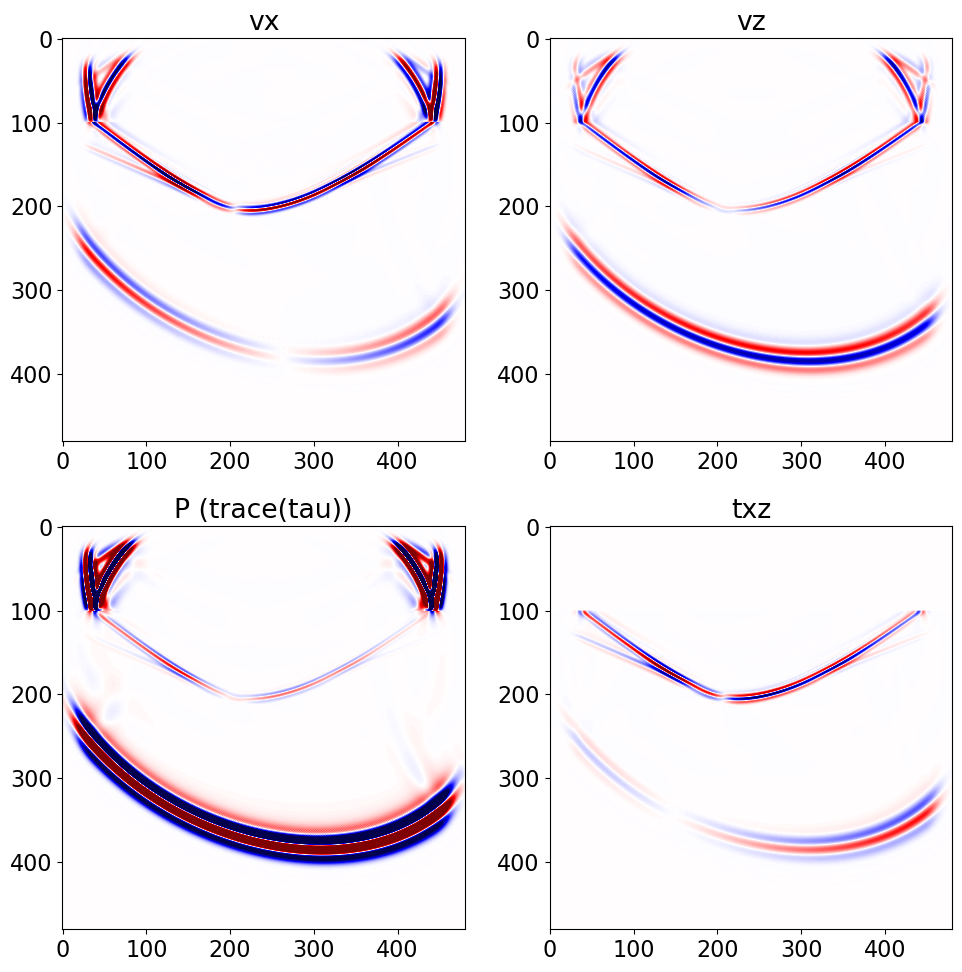

In [12]:
scale = 1e-2
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(v[0].data[0].T, vmin=-scale, vmax=scale, cmap="seismic")
plt.title("vx")
plt.subplot(222)
plt.imshow(v[1].data[0].T, vmin=-scale, vmax=scale, cmap="seismic")
plt.title("vz")
plt.subplot(223)
plt.imshow(tau[0, 0].data[0].T + tau[1, 1].data[0].T, vmin=-scale, vmax=scale, cmap="seismic")
plt.title("P (trace(tau))")
plt.subplot(224)
plt.imshow(tau[0, 1].data[0].T, vmin=-scale, vmax=scale, cmap="seismic")
plt.title("txz")
plt.tight_layout()
plt.savefig("2DETTI.png", bbox_inches="tight")

plt.show()